<a href="https://colab.research.google.com/github/Ritishh00/GEN-AI/blob/main/GEN_AI_29_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError , KLDivergence , BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
# Import ModelCheckpoint and EarlyStopping from tensorflow.keras.callbacks instead of tensorflow.keras.optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from skimage.transform import resize

In [ ]:
# %%
from tensorflow.keras.datasets import cifar10  # Import the cifar10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # Load the CIFAR-10 dataset
# %%


In [ ]:
x_train = x_train.astype('float32') / 255.0  # Normalize the training data
x_test = x_test.astype('float32') / 255.0  # Normalize the testing data


In [ ]:
latent_dim = 1024
image_shape = x_train[0].shape  # Get the shape directly using .shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy # Import binary_crossentropy


class VAE(keras.Model):
  def __init__(self, latent_dim, image_shape, beta):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.beta=beta

    self.encoder = keras.Sequential([
        layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
        layers.Conv2D(32, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_2"),
        layers.Conv2D(64, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_4"),
        layers.Conv2D(128, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_6"),
        layers.Flatten(name="Encoder_Flatten"),
        ])

    # First, define self.z to hold the mean and log_var layers.
    self.z_mean = layers.Dense(latent_dim, name="z_Mean")
    self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

    self.decoder = keras.Sequential([
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(8*8*64, activation='relu'),
        layers.Reshape((8,8,64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])

    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  def encode(self,data):
    x=self.encoder(data)
    # Access z_mean and z_log_var directly
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    return z_mean, z_log_var

  def reparameterization(self,z_mean, z_log_var):
    batch=tf.shape(z_mean)[0]
    dim=tf.shape(z_mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch, dim))
    z=z_mean+tf.exp(0.5*z_log_var)*epsilon
    return z

  def call(self,x):
    mean, logvar=self.encode(x)
    z=self.reparameterization(mean, logvar)
    x_recon=self.decode(z)
    return x_recon, mean, logvar

  def decode(self,data):
    return self.decoder(data)

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def recon_loss(self,data,reconstruction):
    # Use binary_crossentropy from tensorflow.keras.losses
    return tf.reduce_mean(binary_crossentropy(data,reconstruction))

  def kl_divergence(self, Z_logvar, Z_mu):
    kl_loss = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
    return self.beta*kl_loss # Return kl_loss instead of just kl

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encode(data)
      z = self.reparameterization(z_mean, z_log_var)
      reconstruction = self.decode(z)

      reconstruction_loss = self.recon_loss(data, reconstruction)
      kl_loss = self.kl_divergence(z_log_var, z_mean)
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

In [ ]:
  vae = VAE(latent_dim, image_shape, 0.3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - kl_loss: 7.3547e-04 - loss: 0.6868 - reconstruction_loss: 0.6860
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - kl_loss: 0.0081 - loss: 0.6280 - reconstruction_loss: 0.6199
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - kl_loss: 0.0107 - loss: 0.6189 - reconstruction_loss: 0.6082
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0124 - loss: 0.6145 - reconstruction_loss: 0.6021
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0130 - loss: 0.6118 - reconstruction_loss: 0.5988
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0134 - loss: 0.6109 - reconstruction_loss: 0.5975
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - kl_loss: 0.0139 - loss: 0.6093 - reconstruction_loss: 0.5953
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0139 - loss: 0.6076 - reconstruction_loss: 0.5937
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0136 - loss: 0.605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


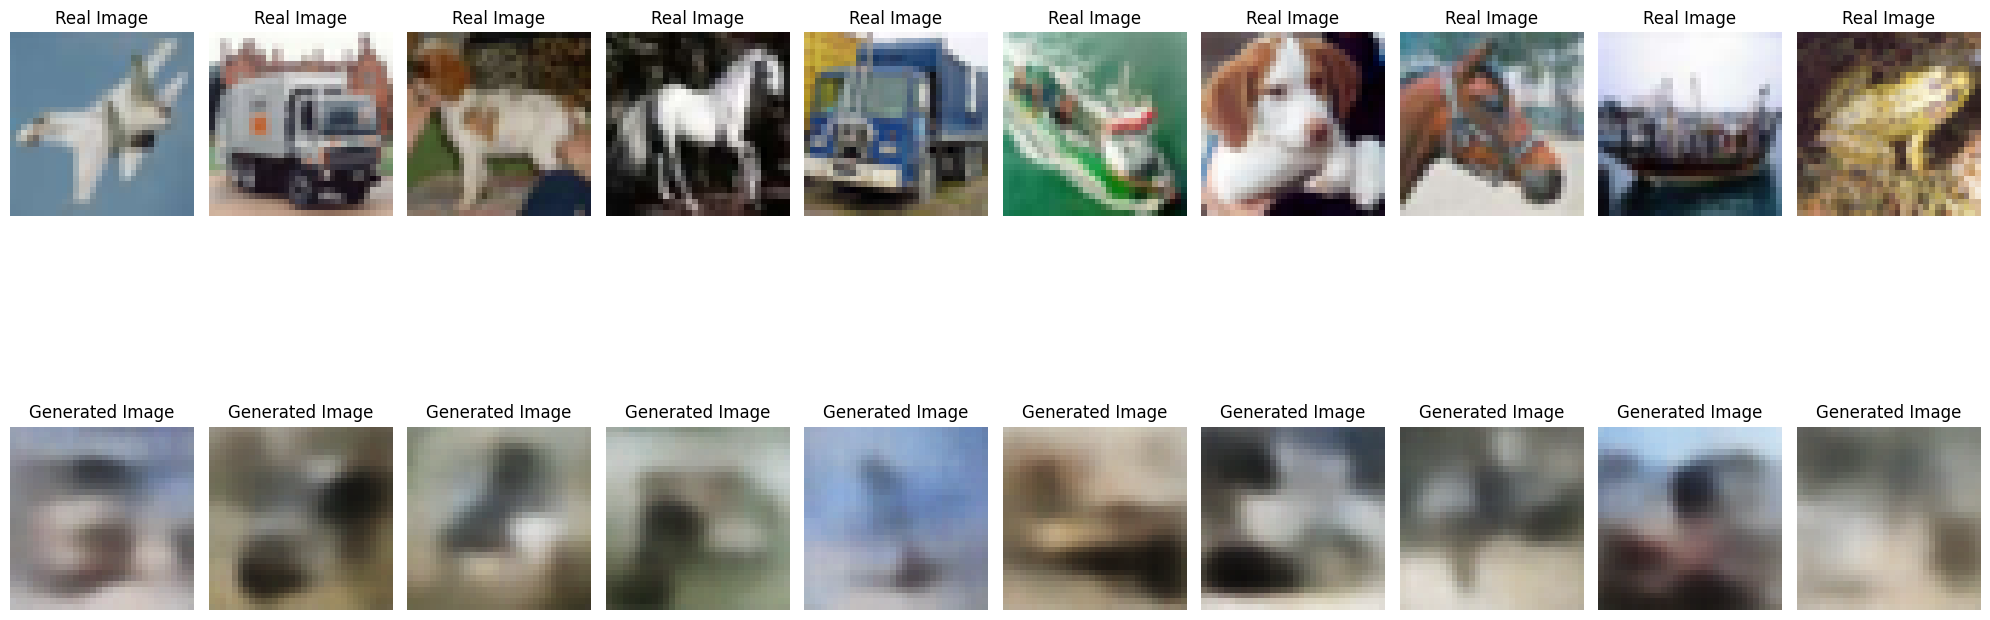

In [ ]:
def generate_images_from_latent_vectors(vae,num_images_to_generate):
  random_latent_vectors = np.random.normal(size=(num_images_to_generate, vae.latent_dim))
  generated_images = vae.decoder.predict(random_latent_vectors)
  return generated_images
# Call the function to generate images and assign the result to generated_images in global scope
generated_images = generate_images_from_latent_vectors(vae,20) # This line moved outside the function

def plot_real_and_generated_images(real_images, generated_images,num_images_to_generate):
    plt.figure(figsize=(20, 10))
    for i in range(num_images_to_generate):
        plt.subplot(2,num_images_to_generate,i+1)
        plt.imshow(real_images[i+10])
        plt.title('Real Image')
        plt.axis('off')
    for i in range(num_images_to_generate):
        plt.subplot(2,num_images_to_generate,num_images_to_generate + i + 1)
        plt.imshow(generated_images[i+10])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_real_and_generated_images(x_test, generated_images, 10)

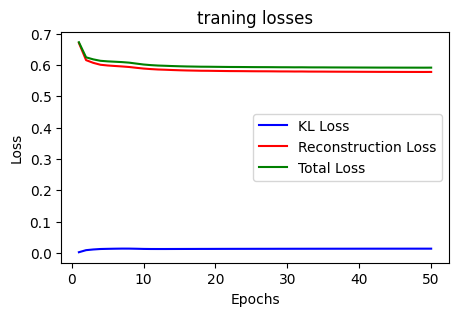

In [ ]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
# The total loss is stored under the key "loss"
total_loss = history.history['loss']
epochs = range(1, len(kl_loss) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('traning losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**12-02-25**

In [ ]:
!pip install torch torchvision
!pip install matplotlib
!pip install torchvision --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 784)
        self.fc5 = nn.Linear(10284, 28*28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))
        return x.view(x.size(0), 1, 28, 28)

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return self.fc4(x)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return -torch.mean(y_true * y_pred)

In [ ]:
def compute_gradient_penalty(critic, real_images,fake_images, device):
    batch_size, C, H, W = real_images.size()
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)
    critic_outputs = critic(interpolated_images)
    gradient = torch.autograd.grad(
        outputs=critic_outputs,inputs = interpolated_images,
        grad_outputs=torch.ones(critic_outputs.size()).to(device),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradient.norm(2, dim=1) - 1) ** 2).mean()
    return penalty

In [ ]:
z_dim = 100
lr = 0.00005
n_critic = 5
lambda_gp = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)

            critic_real = critic(real_images)
            critic_fake = critic(fake_images)

            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)

            critic_loss = torch.mean(critic_fake) - torch.mean(critic_real) + lambda_gp * gradient_penalty

            optim_critic.zero_grad()
            critic_loss.backward(retain_graph=True)
            optim_critic.step()

        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        critic_fake = critic(fake_images)

        gen_loss = -torch.mean(critic_fake)

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x784 and 10284x784)

**19-02-25**

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

import tensorflow as tf
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Changed 'model.dd' to 'model.add'
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


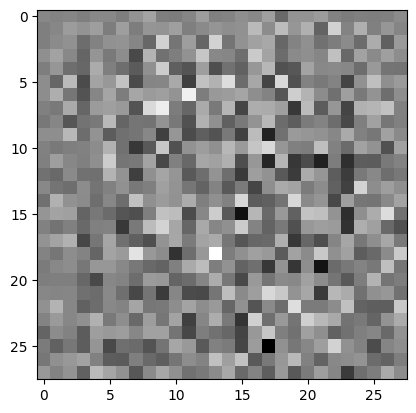

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00139505]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
